In [1]:
# %load /Users/ZHHR/Desktop/DS_GA_1003/Project/stock_project/KNN/baseline.py

import sys, os
sys.path.append(os.path.join(os.path.dirname("__file__"), '..'))
import numpy as np
import datetime
from __future__ import division
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn import decomposition
from sklearn.tree import DecisionTreeClassifier
from model_prep import feature_generator as fg
from model_prep import data_util as ut
from model_eval import supervised_eval as se
from matplotlib import pyplot as plt
%matplotlib inline
def baseline_data(dataset,d1,d2,option):
    
    #load tickers data
    F, IT, C, I = ut.load_ticker_data(dataset)
    
    #construct y labels
    F_y, IT_y, C_y, I_y = ut.construct_y(F, IT, C, I)
    
    #construct train_X
    F_X = fg.get_basic_records(F, d1, d2, option)
    IT_X = fg.get_basic_records(IT, d1, d2, option)
    C_X = fg.get_basic_records(C, d1, d2, option)
    I_X = fg.get_basic_records(I, d1, d2, option)
    
    #finalize train and test data
    X, y = ut.finalize_data(F_X,IT_X,C_X,I_X,
                            F_y,IT_y,C_y,I_y)

    return X, y


def baseline_model(X_train,y_train,X_test,y_test):
    
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(X_train, y_train)
    predicted = neigh.predict(X_test)
    
    return predicted

## Random Forrest

In [16]:
def RF_model(X_train,y_train,X_test,y_test):
    #F = RandomForestClassifier(n_estimators=300, criterion='gini', max_depth=None, min_samples_split=8, min_samples_leaf=3, max_features='auto', max_leaf_nodes=4)
    F = RandomForestClassifier(n_estimators=500)
    F.fit(X_train, y_train)
    predict = F.predict(X_test)
    return predict

In [19]:
d1 = datetime.datetime(2005, 1, 1)
d2 = datetime.datetime(2014, 12, 31)
option = "return rate"
train_X,train_y = baseline_data("training",d1,d2,option)
test_X,test_y = baseline_data("validation",d1,d2,option)
# train_X_raw,train_y = baseline_data("training",d1,d2,option)
# test_X_raw,test_y = baseline_data("validation",d1,d2,option)
# train_X = normalize(train_X_raw)
# test_X = normalize(test_X_raw)
# pca = decomposition.PCA(n_components=100)
# pca.fit(train_X)
# train_XX = pca.transform(train_X)
# test_XX = pca.transform(test_X)
predicted = RF_model(train_X, train_y, test_X, test_y)
se.evaluate_matrix(test_y,predicted)


===========ACCURACY===========

89.57%

===========Comfusion Matrix===========

    F  IT  C  I
F  [31  1  0  1]
IT [ 0 24  0  3]
C  [ 0  2 23  2]
I  [ 0  3  0 25]

===========Precision, Recall, F-score===========

               F           IT         C          I 
Precision [ 1.          0.8         1.          0.80645161]
Recall    [ 0.93939394  0.88888889  0.85185185  0.89285714]
F-score   [ 0.96875     0.84210526  0.92        0.84745763]

Average precision: 90.16%, recall: 89.32%, F-score: 89.46%


##Decision Tree

In [65]:
train_X_raw,train_y = baseline_data("training",d1,d2,option)
test_X_raw,test_y = baseline_data("validation",d1,d2,option)
train_X = normalize(train_X_raw)
test_X = normalize(test_X_raw)

train_err_list = []
test_err_list = []

for i in range(2, 20):
#     # Standardize
#     mean = X.mean(axis=0)
#     std = X.std(axis=0)
#     X = (X - mean) / std
#     mean_test = X_test.mean(axis=0)
#     std_test = X_test.std(axis=0)
#     X_test = (X_test - mean_test) / std_test

    # Train
    clf = DecisionTreeClassifier(max_depth=i+2, min_samples_split=2, min_samples_leaf=1, max_features=None, max_leaf_nodes=None).fit(train_X, train_y)
    y_train_pred = clf.predict(train_X)
    y_test_pred = clf.predict(test_X)
    train_err = 1-accuracy_score(train_y, y_train_pred)
    train_err_list.append(train_err)
    test_err = 1-accuracy_score(test_y, y_test_pred)
    test_err_list.append(test_err)
    print i,
    
print min(test_err_list)

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.4


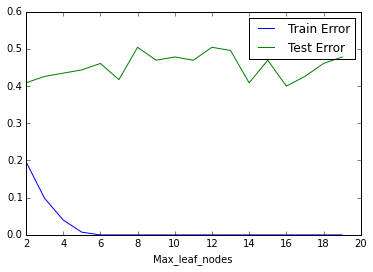

In [66]:
plt.plot(range(2, 20), train_err_list, label = 'Train Error')
plt.plot(range(2, 20), test_err_list, label = 'Test Error')
plt.xlabel('Max_leaf_nodes')
plt.legend()
plt.show()

##Adaboost

In [97]:

# Initialize weights
n_train = len(train_y)
n_test = len(test_y)
w_0_train = np.ones(n_train)/n_train


# Create two arrays to store train and test errors
ERR_train = np.zeros(20)
ERR_test = np.zeros(20)

# Adaboost
for m in range(1, 21):
    w = w_0_train
    PRED_train = np.zeros(n_train)
    PRED_test = np.zeros(n_test)
    for j in range(1, m+1):
        clf = DecisionTreeClassifier(max_depth=3, min_samples_split=2, min_samples_leaf=1)
        clf.fit(train_X, train_y, sample_weight = w)
        y_train_pred = clf.predict(train_X)
        y_test_pred = clf.predict(test_X)
        err = (1/float(np.sum(w)))*np.sum(w*((y_train_pred!=train_y).astype(float)))
        alpha = np.log((1-err)/err)
        w = w*np.exp(alpha*((y_train_pred!=train_y).astype(float)))        
        PRED_train += alpha*y_train_pred
        PRED_test += alpha*y_test_pred
    PRED_train = np.sign(PRED_train)
    PRED_test = np.sign(PRED_test)
    ERR_train[m-1] = 1-accuracy_score(train_y, PRED_train)
    ERR_test[m-1] = 1-accuracy_score(test_y, PRED_test)
    #print m, ERR_train[m-1], ERR_test[m-1]

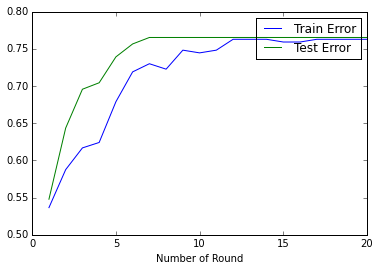

In [98]:
plt.plot(range(1, 21), ERR_train, label = 'Train Error')
plt.plot(range(1, 21), ERR_test, label = 'Test Error')
plt.xlabel('Number of Round')
plt.legend()
plt.show()

In [20]:
symbol_dict = {
    'TOT': 'Total',
    'XOM': 'Exxon',
    'CVX': 'Chevron',
    'COP': 'ConocoPhillips',
    'VLO': 'Valero Energy',
    'MSFT': 'Microsoft',
    'IBM': 'IBM',
    'TWX': 'Time Warner',
    'CMCSA': 'Comcast',
    'CVC': 'Cablevision',
    'YHOO': 'Yahoo',
    'DELL': 'Dell',
    'HPQ': 'HP',
    'AMZN': 'Amazon',
    'TM': 'Toyota',
    'CAJ': 'Canon',
    'MTU': 'Mitsubishi',
    'SNE': 'Sony',
    'F': 'Ford',
    'HMC': 'Honda',
    'NAV': 'Navistar',
    'NOC': 'Northrop Grumman',
    'BA': 'Boeing',
    'KO': 'Coca Cola',
    'MMM': '3M',
    'MCD': 'Mc Donalds',
    'PEP': 'Pepsi',
    'MDLZ': 'Kraft Foods',
    'K': 'Kellogg',
    'UN': 'Unilever',
    'MAR': 'Marriott',
    'PG': 'Procter Gamble',
    'CL': 'Colgate-Palmolive',
    'GE': 'General Electrics',
    'WFC': 'Wells Fargo',
    'JPM': 'JPMorgan Chase',
    'AIG': 'AIG',
    'AXP': 'American express',
    'BAC': 'Bank of America',
    'GS': 'Goldman Sachs',
    'AAPL': 'Apple',
    'SAP': 'SAP',
    'CSCO': 'Cisco',
    'TXN': 'Texas instruments',
    'XRX': 'Xerox',
    'LMT': 'Lookheed Martin',
    'WMT': 'Wal-Mart',
    'WBA': 'Walgreen',
    'HD': 'Home Depot',
    'GSK': 'GlaxoSmithKline',
    'PFE': 'Pfizer',
    'SNY': 'Sanofi-Aventis',
    'NVS': 'Novartis',
    'KMB': 'Kimberly-Clark',
    'R': 'Ryder',
    'GD': 'General Dynamics',
    'RTN': 'Raytheon',
    'CVS': 'CVS',
    'CAT': 'Caterpillar',
    'DD': 'DuPont de Nemours'}
 

In [21]:
len(symbol_dict)

60